In [ ]:
import datastore

import pandas as pd
import matplotlib.pyplot as plt

spot = datastore.getSpotPrice()

total_consumption_production = datastore.getTotalConsumptionProduction()

production_se1_mwh = datastore.getAllSE1ProductionMWh() 
production_se2_mwh = datastore.getAllSE2ProductionMWh()
production_se3_mwh = datastore.getAllSE3ProductionMWh()
production_se4_mwh = datastore.getAllSE4ProductionMWh()

transTo = datastore.getTransmissionCapTo()
transFrom = datastore.getTransmissionCapFrom()

# netFlow = datastore.getNetFlow() # Too many missing values
flow = datastore.getFlow()

capTo = datastore.getFlowCapacityTo()
capFrom = datastore.getFlowCapacityFrom()

exchangeFrom = datastore.getExchangeFrom()
# exchangeNet = datastore.getNetExchange()

turnOver = datastore.getTurnover()

pen = datastore.getDailyPerc() 
hydroReservoirs = datastore.getWeeklyHydro() # GWh

windspeeds = pd.read_csv('windspeeds_aggregated.csv' , sep=';', parse_dates=True, index_col=0)
temp = pd.read_csv('temp_agg.csv' , sep=';', parse_dates=True, index_col=0)

In [ ]:
import calendar_features as cf

dataset = pd.concat([spot, total_consumption_production,
                     production_se1_mwh, production_se2_mwh, production_se3_mwh, production_se4_mwh,  
                     flow, capTo, capFrom, exchangeFrom,
                     turnOver, pen, hydroReservoirs, windspeeds, temp, transTo, transFrom], axis=1)

dataset.interpolate(method = 'linear', limit_direction = 'forward', inplace=True, axis=0)

# daylight_features = cf.daylight_extractor(dataset)    
holiday_features = cf.get_holidays(dataset)
dataset = cf.calendar_transformer(dataset)

dataset = pd.concat([dataset, holiday_features], axis=1)
dataset = pd.get_dummies(dataset, columns=["year", "month", "day_of_week", "hour"])
dataset['weekend'] = dataset['weekend'].astype('bool')
dataset['holidays'] = dataset['holidays'].astype('bool')

dataset.info()

In [1]:
import pandas as pd

dataset = pd.read_csv('dataset.csv', sep=';', parse_dates=True, index_col=0)

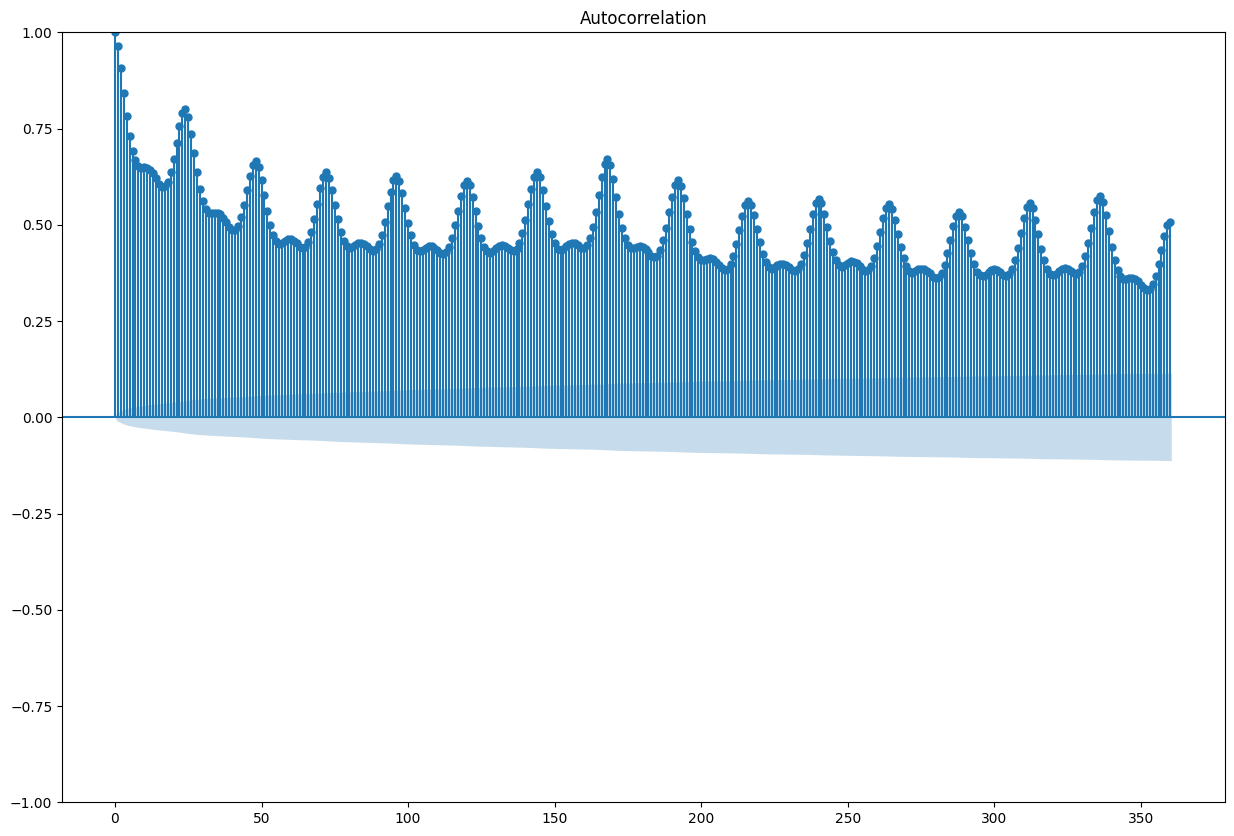

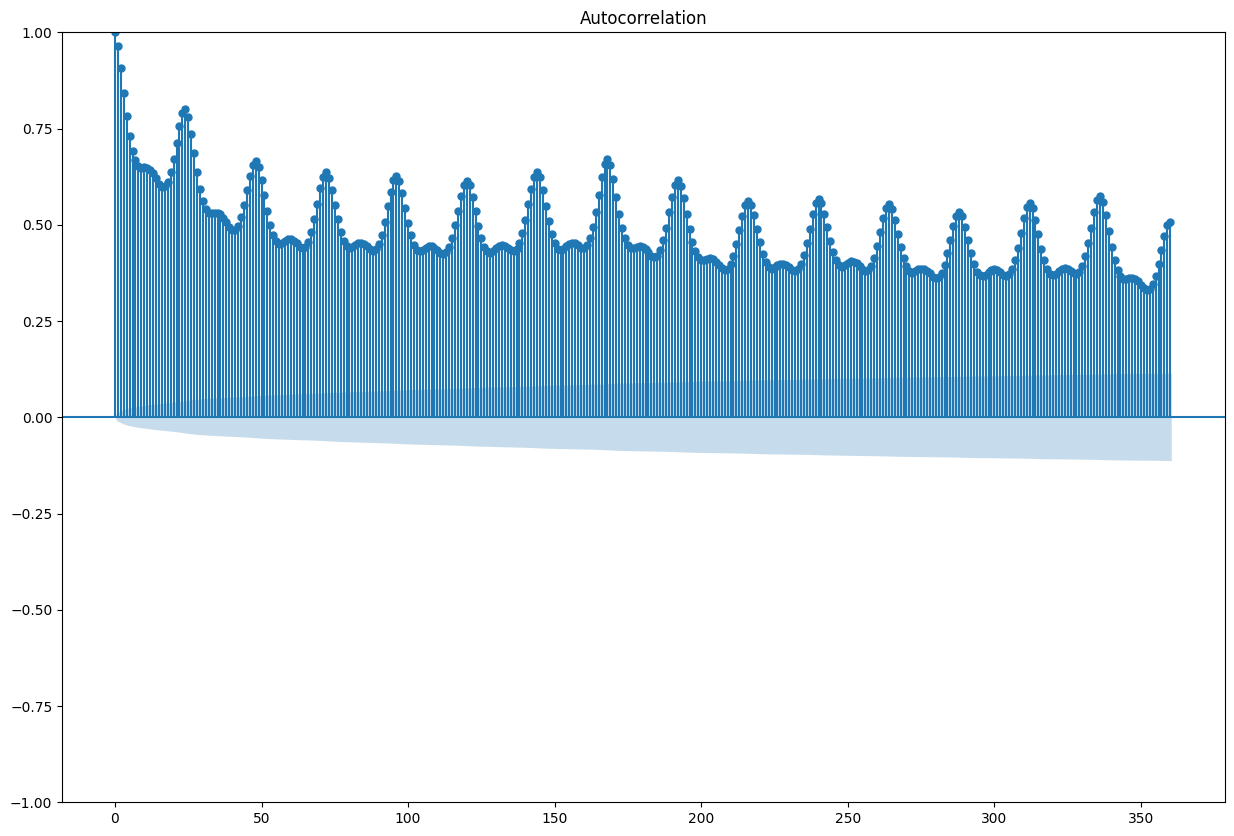

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

ax, fig = plt.subplots(figsize=(15, 10))

plot_acf(dataset['spotPrice'], lags= (360), alpha=.05, missing='drop', use_vlines=True, ax=fig)

In [1]:
import pandas as pd

dataset = pd.read_csv('dataset.csv', sep=';', parse_dates=True, index_col=0)
spot = dataset['spotPrice']

spot_lag_24 = spot.shift(24).to_frame().add_suffix('_24')
spot_lag_48 = spot.shift(48).to_frame().add_suffix('_48')
spot_lag_72 = spot.shift(72).to_frame().add_suffix('_72')
spot_lag_96 = spot.shift(96).to_frame().add_suffix('_96')
spot_lag_120 = spot.shift(120).to_frame().add_suffix('_120')
spot_lag_168 = spot.shift(168).to_frame().add_suffix('_144')
spot_lag_192 = spot.shift(192).to_frame().add_suffix('_192')
spot_lag_216 = spot.shift(216).to_frame().add_suffix('_216')
spot_lag_240 = spot.shift(240).to_frame().add_suffix('_240')


dataset_ = pd.concat([spot_lag_24, spot_lag_48, spot_lag_72, spot_lag_96, spot_lag_120, spot_lag_168, spot_lag_192, spot_lag_216, spot_lag_240
                    ,dataset]
                    ,axis=1)
dataset = dataset_.dropna()

first_col = dataset.pop('spotPrice')
dataset.insert(0, 'spotPrice', first_col)

In [13]:
import calendar_features as cf

dataset = pd.read_csv('dataset_.csv', sep=';', parse_dates=True, index_col=0)
dataset = cf.calendar_transformer(dataset)

train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'

train_df = dataset.loc[:train_split]
corr_ = train_df.corrwith(train_df['spotPrice']).sort_values(ascending=False)
corr = corr_.abs()

In [19]:
import pandas as pd
import tensorflow as tf
import os

import numpy as np
from sklearn.preprocessing import MinMaxScaler

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

def create_dataset(df, n_deterministic_features,
                   window_size, forecast_size,
                   batch_size):
    # Feel free to play with shuffle buffer size
    shuffle_buffer_size = len(df)
    # Total size of window is given by the number of steps to be considered
    # before prediction time + steps that we want to forecast
    total_size = window_size + forecast_size

    df = df.astype('float32')
    data = tf.data.Dataset.from_tensor_slices(df)
    

    # Selecting windows
    data = data.window(total_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda k: k.batch(total_size))

    # Shuffling data
    data = data.shuffle(shuffle_buffer_size, seed=42)

    # Extracting past features + deterministic future + labels
    data = data.map(lambda k: ((k[:-forecast_size],
                                k[-forecast_size:, -n_deterministic_features:]),
                               k[-forecast_size:, 0]))
    
    #tf.data.experimental.AUTOTUNE
    return data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

dataset = pd.read_csv('dataset.csv', sep=';', parse_dates=True, index_col=0)

futr_exog = dataset.iloc[:, 45:]
hist_exog = dataset.iloc[:, 1:45]
target = dataset['spotPrice']

train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'

hist_train = hist_exog[:train_split]
hist_val = hist_exog[train_split:val_split]
hist_test = hist_exog[val_split:]

futr_train = futr_exog[:train_split]
futr_val = futr_exog[train_split:val_split]
futr_test = futr_exog[val_split:]

target_train = target[:train_split]
target_val = target[train_split:val_split]
target_test = target[val_split:]

hist_train_corr = hist_train.corrwith(dataset['spotPrice']).abs().sort_values(ascending=False)
futr_train_corr = futr_train.corrwith(dataset['spotPrice']).abs().sort_values(ascending=False)
hist_train = hist_train[hist_train_corr[hist_train_corr > 0].index]
hist_val = hist_val[hist_train.columns]
hist_test = hist_test[hist_train.columns]

futr_train = futr_train[futr_train_corr[futr_train_corr > 0].index]
futr_val = futr_val[futr_train.columns]
futr_test = futr_test[futr_train.columns]

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

x_train = pd.concat([hist_train, futr_train], axis=1)
x_val = pd.concat([hist_val, futr_val], axis=1)
x_test = pd.concat([hist_test, futr_test], axis=1)

scaler_features.fit(x_train)
scaler_target.fit(target_train.to_frame())

x_train = scaler_features.transform(x_train)
x_val = scaler_features.transform(x_val)
x_test = scaler_features.transform(x_test)

target_train = scaler_target.transform(target_train.to_frame())
target_val = scaler_target.transform(target_val.to_frame())
target_test = scaler_target.transform(target_test.to_frame())

train = np.concatenate([target_train, x_train], axis=1)
val = np.concatenate([target_val, x_val], axis=1)
test = np.concatenate([target_test, x_test], axis=1)

total_features = train.shape[1]
hist_exog_list = len(hist_train.columns.to_list()) + 1
futr_exog_list = train.shape[1] - hist_exog_list

window_len = 24 * 5 * 4
forecast_len = 24 * 5

batch_size = 64

training_windowed = create_dataset(train,
                                   futr_exog_list,
                                   window_len,
                                   forecast_len,
                                   batch_size)

validation_windowed = create_dataset(val,
                                     futr_exog_list,
                                     window_len,
                                     forecast_len,
                                     batch_size)

test_windowed = create_dataset(test,
                               futr_exog_list,
                               window_len,
                               forecast_len,
                               batch_size=1)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

dataset = pd.read_csv('dataset.csv', sep=';', parse_dates=True, index_col=0)

def create_dataset(df, n_deterministic_features,
                   window_size, forecast_size,
                   batch_size):
    # Feel free to play with shuffle buffer size
    shuffle_buffer_size = len(df)
    # Total size of window is given by the number of steps to be considered
    # before prediction time + steps that we want to forecast
    total_size = window_size + forecast_size

    df = df.astype('float32')
    data = tf.data.Dataset.from_tensor_slices(df)
    
    # Selecting windows
    data = data.window(total_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda k: k.batch(total_size))

    # Shuffling data
    data = data.shuffle(shuffle_buffer_size, seed=42)

    # Extracting past features + deterministic future + labels
    data = data.map(lambda k: ((k[:-forecast_size],
                                k[-forecast_size:, -n_deterministic_features:]),
                               k[-forecast_size:, 0]))
    
    return data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'

train_df = dataset.loc[:train_split]
val_df = dataset.loc[train_split:val_split]
test_df = dataset.loc[val_split:]

x_train = train_df.iloc[:, 1:]
y_train = train_df.iloc[:, 0]

x_val = val_df.iloc[:, 1:]
y_val = val_df.iloc[:, 0]

x_test = test_df.iloc[:, 1:]
y_test = test_df.iloc[:, 0]

scaler = MinMaxScaler()
scaler_target = MinMaxScaler()

scaler.fit(x_train)
scaler_target.fit(y_train.values.reshape(-1, 1))

x_train = scaler.transform(x_train)
y_train = scaler_target.transform(y_train.values.reshape(-1, 1))

x_val = scaler.transform(x_val)
y_val = scaler_target.transform(y_val.values.reshape(-1, 1))

x_test = scaler.transform(x_test)
y_test = scaler_target.transform(y_test.values.reshape(-1, 1))

In [2]:
dataset.iloc[:, 1:40].columns.to_list()

['ConsumptionGWh',
 'ProductionGWh',
 'waterSE1(MWh)',
 'windSE1(MWh)',
 'trmSE1MWh',
 'waterSE2(MWh)',
 'windSE2(MWh)',
 'solSE2MWh',
 'trmSE2MWh',
 'OthSE2MWh',
 'waterSE3(MWh)',
 'windSE3(MWh)',
 'nucSE3(MWh)',
 'solSE3MWh',
 'trmSE3MWh',
 'OthSE3MWh',
 'waterSE4(MWh)',
 'windSE4(MWh)',
 'solSE4MWh',
 'trmSE4MWh',
 'OthSE4MWh',
 'F_LOWSE2SE3',
 'F_LOWSE3FI',
 'F_LOWSE3SE4',
 'C_SE4SE3',
 'C_DK1SE3',
 'C_FISE3',
 'C_NO1SE3',
 'C_SE2SE3',
 'C_SE3DK1',
 'C_SE3FI',
 'C_SE3NO1',
 'C_SE3SE2',
 'C_SE3SE4',
 'TurnoverB',
 'TurnoverS',
 'PrecipitationEnergySE(day)',
 'HydroRes(GWh_week)',
 'HydroBalance(GWh_week)']

In [2]:
train_val_x = np.concatenate([x_train, x_val], axis = 0)
train_val_y = np.concatenate([y_train, y_val], axis = 0)
train_val = np.concatenate([train_val_x, train_val_y], axis = 1) 

train = np.concatenate([y_train, x_train], axis=1)
val = np.concatenate([y_val, x_val], axis=1)
test = np.concatenate([y_test, x_test], axis=1)

total_features = train.shape[1]
futr_exog_list = len(dataset.iloc[:, 40:].columns.to_list())
hist_exog_list = len(dataset.iloc[:, 1:40].columns.to_list())

window_len = 24 * 5 * 4
forecast_len = 24 * 5

batch_size = 64

train_val_windowed = create_dataset(train_val, futr_exog_list, 
                                    window_len, forecast_len, batch_size)
training_windowed = create_dataset(train, futr_exog_list, 
                                   window_len, forecast_len,
                                   batch_size)

validation_windowed = create_dataset(val, futr_exog_list,
                                     window_len, forecast_len,
                                     batch_size)

test_windowed = create_dataset(test, futr_exog_list,
                               window_len, forecast_len,
                               batch_size=1)

C:\Users\drami\AppData\Local\Temp\ipykernel_4340\3580422332.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


<Axes: >

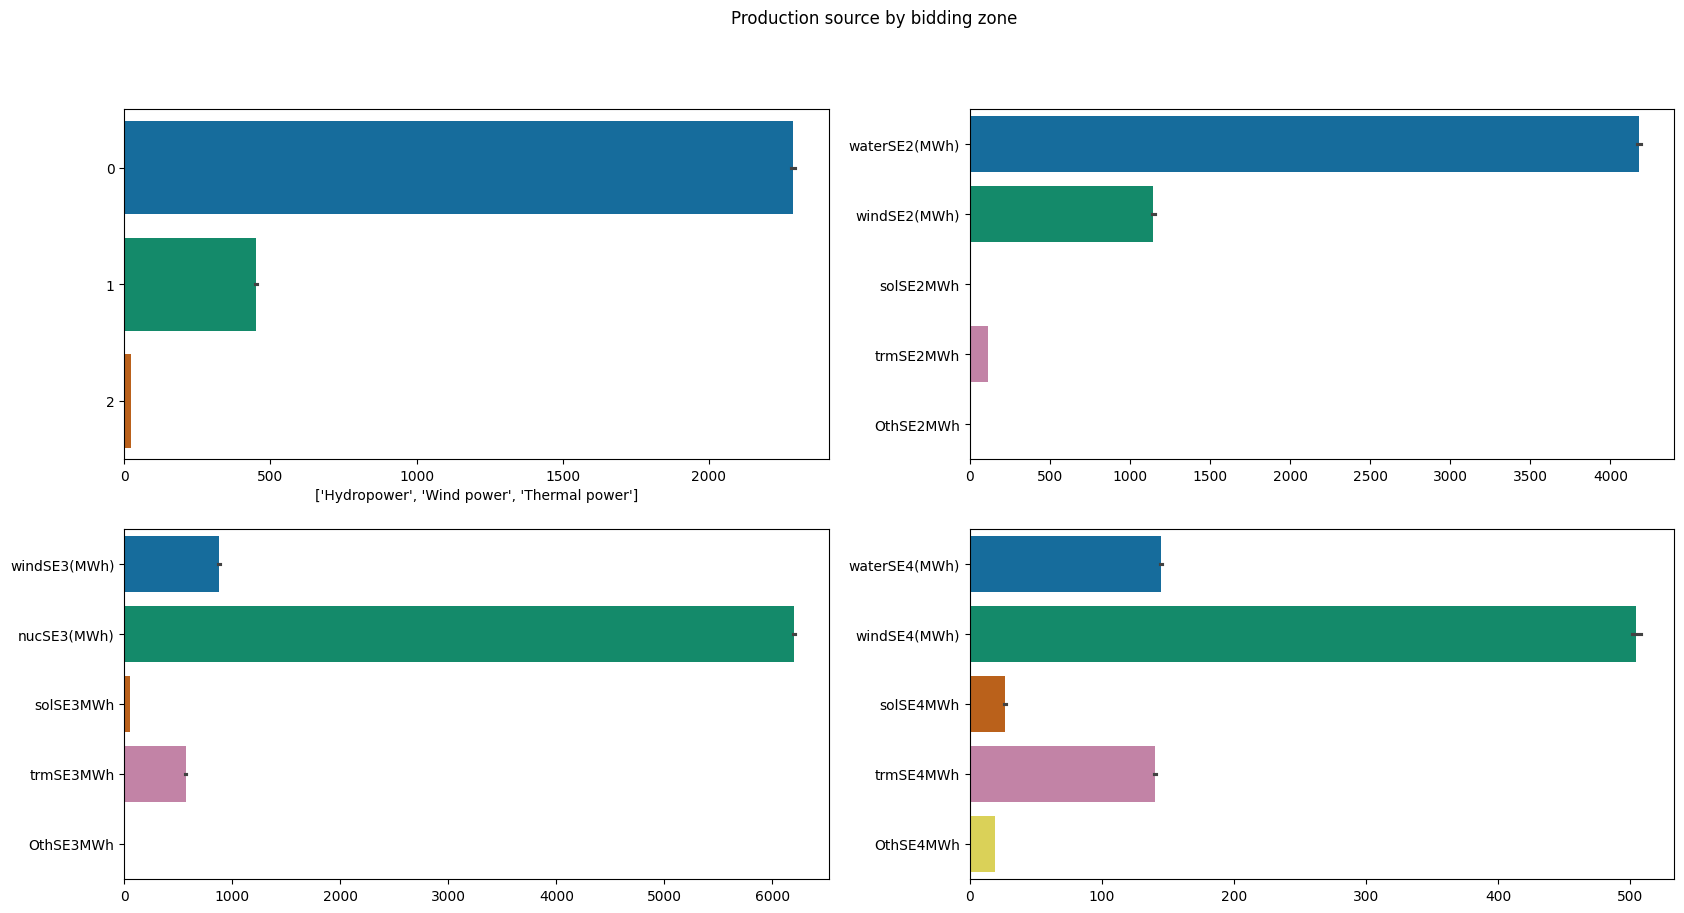

In [61]:
production = dataset.iloc[:, 3:22]
production_se1 = production.iloc[:, :3]
production_se2 = production.iloc[:, 3:8]
production_se3 = production.iloc[:, 9:14]
production_se4 = production.iloc[:, 14:]

import seaborn as sns
import matplotlib.pyplot as plt

#plt.figure(figsize=(12, 5))
plt.style.use('seaborn-colorblind')
fig, axes = plt.subplots(2,2, figsize = (20, 10), squeeze=True, sharey=False)
fig.suptitle("Production source by bidding zone")

se1 = ["Hydropower", "Wind power", "Thermal power"]
se2 = ["Hydropower", "Wind power", "Solar power", "Thermal power", "Other sources"]
se3 = ["Wind power", "Nuclear power", "Solar power", "Thermal power", "Other sources"]
se2 = ["Hydropower", "Wind power", "Solar power", "Thermal power", "Other sources"]
p1 = sns.barplot(ax = axes[0, 0], data = production_se1.values, orient='y')
p1.set_xlabel(se1)
sns.barplot(ax = axes[0, 1], data = production_se2, orient='y')
sns.barplot(ax = axes[1, 0], data = production_se3, orient='y')
sns.barplot(ax = axes[1, 1], data = production_se4, orient='y')

In [121]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def smape(A, F):
    from keras import ops
    return 1/len(A) * ops.sum(2 * ops.abs(F - A) / (ops.abs(A) + ops.abs(F)))

y_true = pd.DataFrame(scaler_target.inverse_transform(test[:, 0].reshape(-1, 1)))
persistance_test = y_true.shift(120)

persistance = pd.concat([y_true, persistance_test], axis=1)


persistence_mae = mean_absolute_error(persistance.iloc[120:, 0], persistance.iloc[120:, 1])
persistence_mse = mean_squared_error(persistance.iloc[120:, 0], persistance.iloc[120:, 1])
persistence_rmse = np.sqrt(persistence_mse)
persistence_smape = smape(persistance.iloc[120:, 0], persistance.iloc[120:, 1])

In [ ]:
import keras
from keras.layers import LSTM, Dense, Input, Dropout, Bidirectional

keras.backend.clear_session()

N = x_train.shape[0]
length_scale = 1e-2
dropout = 0.2
tau = 1.0
reg = (length_scale**2 * (1-dropout)) / (2. * N * tau)


latent_dim = 64

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = Input(shape=(window_len, total_features), 
                          name='encoder_inputs')

# Encoding the past
encoder = LSTM(latent_dim, name='encoder', return_state=True, kernel_regularizer=keras.regularizers.L2(reg))
encoder_outputs, forward_state_h, forward_state_c = encoder(past_inputs) 
encoder_states = [forward_state_h, forward_state_c]

future_inputs = Input(shape=(forecast_len, futr_exog_list), 
                            name='decoder_inputs')
# Combining future inputs with recurrent branch output

decoder_lstm = (LSTM(latent_dim, return_sequences=True, 
                    recurrent_dropout=0.2, dropout= dropout, 
                    name='decoder', kernel_regularizer=keras.regularizers.L2(reg)))

decoder_outputs = decoder_lstm(future_inputs, initial_state=encoder_states, training = True)
x = Dense(32, activation='relu', kernel_regularizer=keras.regularizers.L2(reg))(decoder_outputs)

output = (Dense(1, activation='relu'))(x)

model = keras.Model(inputs=[past_inputs, future_inputs], 
                           outputs=output)

learning_rate = 1.585e-07
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.MeanAbsoluteError()
metrics = [keras.metrics.RootMeanSquaredError(), keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError()]

model.compile(loss=loss, 
              optimizer=optimizer,
              metrics = metrics)

model.summary()

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 7, restore_best_weights=True, verbose=1, mode='min')

history = model.fit(training_windowed, 
                    epochs=25,
                    validation_data=validation_windowed, 
                    callbacks=[early_stopping])

In [ ]:
model.evaluate(test_windowed, return_dict=True)

In [ ]:
tf.keras.backend.clear_session()

def smape(y_true, y_pred):
    from tensorflow import math
    
    return 100 * math.reduce_mean(2 * math.abs(y_pred - y_true) / (math.abs(y_true) + math.abs(y_pred)))

latent_dim = 64

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = tf.keras.Input(shape=(window_len, total_features), 
                          name='encoder_inputs')
# Encoding the past
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder(past_inputs) 

future_inputs = tf.keras.Input(shape=(forecast_len, futr_exog_list), 
                            name='decoder_inputs')
# Combining future inputs with recurrent branch output
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, name='decoder_lstm', recurrent_dropout=0.1,
                                    dropout = 0.5)

x = decoder_lstm(future_inputs,
                 initial_state=[state_h, state_c], training = True)

x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1, training = True)(x)

output = tf.keras.layers.Dense(1, activation='relu')(x)
    

model = tf.keras.Model(inputs=[past_inputs, future_inputs], 
                           outputs=output)

lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.MeanAbsoluteError()

metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredError()]

model.compile(loss=loss, 
              optimizer=optimizer,
              metrics = metrics)

model.summary()

In [ ]:
import keras
from keras.layers import LSTM, Dense, Input, Dropout, Bidirectional
from CLR.clr_callback import CyclicLR

keras.backend.clear_session()
latent_dim = 32

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = Input(shape=(window_len, total_features), 
                          name='encoder_inputs')

# Encoding the past
encoder = Bidirectional(LSTM(latent_dim, name='encoder_lstm', return_state=True, recurrent_dropout=0.2, trainable = True))

encoder_outputs, forward_state_h, forward_state_c, backward_state_h, backward_state_c = encoder(past_inputs)
encoder_states = [forward_state_h, forward_state_c, backward_state_h, backward_state_c]

future_inputs = Input(shape=(forecast_len, futr_exog_list), 
                            name='decoder_inputs')

# Combining future inputs with recurrent branch output
decoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, name='decoder_lstm', recurrent_dropout = 0.3, trainable = True))
x = decoder_lstm(future_inputs, initial_state=encoder_states)
x = Dropout(0.3, trainable = True)(x)

# x = Dense(16, activation='relu')(x)
# x = Dense(16, activation='relu')(x)

output = Dense(1, activation='relu')(x)

model = keras.Model(inputs=[past_inputs, future_inputs], 
                           outputs=output)

learning_rate = 0.001

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.MeanAbsoluteError()
metrics = [keras.metrics.RootMeanSquaredError(), keras.metrics.MeanSquaredError()]

model.compile(loss=loss, 
              optimizer=optimizer,
              metrics = metrics)

model.summary()

In [5]:
import keras
import keras_tuner as kt
from keras.layers import LSTM, Dense, Input, Dropout, Bidirectional
keras.backend.clear_session()



def build_model(hp):
    units = hp.Int('neurons', min_value=16, max_value=64, step=2, sampling='log') 
    
    decoder_dropout = hp.Float('decoder_dropout', min_value=0.2, max_value=0.9, step=0.2, default = 0.2)
    decoder_dropout_recurrent = hp.Float('decoder_dropout_recurrent', min_value=0.2, max_value=0.9, step=0.2)
    decoder_activation = hp.Choice("decoder_activation", values = ["relu", "tanh"], default = "tanh")
    
    dense_units = hp.Int('dense_units', min_value = 16, max_value = 64, step = 2, sampling = 'log', default = 16)
    dense_dropout = hp.Float('dense_dropout', min_value = 0, max_value = 0.5, step = 0.2, default = 0)
        
    Lrate = hp.Choice('regu_rate_1', values = [0.0, 1e-5, 1e-7])
    learning_rate = hp.Choice("learning_rate", values = [1e-3, 1e-5, 1e-7])
    
    past_inputs = Input(shape=(window_len, total_features), name='past_inputs') 
    
    encoder = LSTM(units, return_state=True)
    _, forward_state_h, forward_state_c = encoder(past_inputs)
    states = [forward_state_h, forward_state_c]
    
    future_inputs = Input(shape=(forecast_len, futr_exog_list), 
                                name='future_inputs')
    
    decoder = LSTM(units, return_sequences=True,
                     recurrent_dropout=decoder_dropout_recurrent,
                     dropout=decoder_dropout, trainable=True,
                     kernel_regularizer=keras.regularizers.L1L2(Lrate, Lrate), activation= decoder_activation)
    
    
    x = decoder(future_inputs, initial_state = states, training = True)
    
    x = Dense(units=dense_units, activation="relu")(x)
    x = Dropout(dense_dropout)(x)
    output = Dense(1, activation= "relu")(x)
    
    model = keras.Model(inputs=[past_inputs, future_inputs], outputs=output)
  
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    loss = keras.losses.MeanAbsoluteError()
    metrics = [keras.metrics.RootMeanSquaredError(), keras.metrics.MeanSquaredError()]
    
    model.compile(loss=loss, optimizer=optimizer, metrics = metrics)
    return model

tuner = kt.Hyperband(build_model,
                        objective='val_loss',
                        max_epochs=15,
                        factor=3,
                        max_retries_per_trial=1,
                        hyperband_iterations=2,
                        overwrite=False)



In [6]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1, mode='min')

tuner.search(training_windowed,
                validation_data=validation_windowed,
                epochs=20,
                callbacks=[early_stopping])

Trial 52 Complete [00h 12m 35s]
val_loss: 0.22018183767795563

Best val_loss So Far: 0.14524011313915253
Total elapsed time: 09h 37m 51s


In [7]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0023 summary
Hyperparameters:
neurons: 32
decoder_dropout: 0.2
decoder_dropout_recurrent: 0.8
decoder_activation: tanh
dense_units: 64
dense_dropout: 0.4
regu_rate_1: 1e-07
learning_rate: 0.001
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.14524011313915253

Trial 0015 summary
Hyperparameters:
neurons: 32
decoder_dropout: 0.4
decoder_dropout_recurrent: 0.2
decoder_activation: tanh
dense_units: 16
dense_dropout: 0.2
regu_rate_1: 0.0
learning_rate: 0.001
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.15084406733512878

Trial 0021 summary
Hyperparameters:
neurons: 16
decoder_dropout: 0.6000000000000001
decoder_dropout_recurrent: 0.8
decoder_activation: tanh
dense_units: 32
dense_dropout: 0.0
regu_rate_1: 1e-05
learning_rate: 0.001
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket

In [8]:
model = tuner.get_best_models(num_models=5)

c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
model[4].evaluate(test_windowed, return_dict=True)

In [9]:
model[2].evaluate(test_windowed, return_dict=True)

8162/8162 ━━━━━━━━━━━━━━━━━━━━ 150s 18ms/step - loss: 0.0529 - mean_squared_error: 0.0049 - root_mean_squared_error: 0.0701


c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'loss': 0.05325012654066086,
 'mean_squared_error': 0.004983675200492144,
 'root_mean_squared_error': 0.0705951526761055}

In [ ]:
import tensorflow as tf
keras.Model.save(model, 'LATEST_best_model_bid2.keras')

In [3]:
import tensorflow as tf
model = tf.keras.models.load_model('LATEST_best_model_single.keras')

c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [20]:
from CLR.clr_callback import CyclicLR


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True, verbose=1, mode='min')
clr = CyclicLR(base_lr=learning_rate, max_lr=0.001,
                        step_size=2000., mode='triangular2')

history = model.fit(training_windowed, 
                    epochs=100,
                    validation_data=validation_windowed, 
                    callbacks=[early_stopping, clr])

Epoch 1/100
    539/Unknown 95s 155ms/step - loss: 0.0587 - mean_absolute_error: 0.0587 - mean_squared_error: 0.0064 - root_mean_squared_error: 0.0793

c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


539/539 ━━━━━━━━━━━━━━━━━━━━ 103s 169ms/step - loss: 0.0587 - mean_absolute_error: 0.0587 - mean_squared_error: 0.0064 - root_mean_squared_error: 0.0793 - val_loss: 0.1715 - val_mean_absolute_error: 0.1715 - val_mean_squared_error: 0.0677 - val_root_mean_squared_error: 0.2601
Epoch 2/100
Epoch 2/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 92s 153ms/step - loss: 0.0206 - mean_absolute_error: 0.0206 - mean_squared_error: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.1717 - val_mean_absolute_error: 0.1717 - val_mean_squared_error: 0.0673 - val_root_mean_squared_error: 0.2595
Epoch 3/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 91s 151ms/step - loss: 0.0171 - mean_absolute_error: 0.0170 - mean_squared_error: 0.0011 - root_mean_squared_error: 0.0328 - val_loss: 0.1634 - val_mean_absolute_error: 0.1634 - val_mean_squared_error: 0.0613 - val_root_mean_squared_error: 0.2475
Epoch 4/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 92s 152ms/step - loss: 0.0156 - mean_absolute_error: 0.0156 - mean_squared_error: 9.3273e-04 -

In [21]:
model.evaluate(test_windowed, return_dict=True)

8162/8162 ━━━━━━━━━━━━━━━━━━━━ 83s 10ms/step - loss: 0.0500 - mean_absolute_error: 0.0500 - mean_squared_error: 0.0046 - root_mean_squared_error: 0.0675


c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'loss': 0.05001959577202797,
 'mean_absolute_error': 0.050018925219774246,
 'mean_squared_error': 0.004581770393997431,
 'root_mean_squared_error': 0.06768877804279327}

In [4]:
import keras 


def smape(A, F):
    from keras import ops
    return 1/len(A) * ops.sum(2 * ops.abs(F - A) / (ops.abs(A) + ops.abs(F)))

learning_rate = model.optimizer.get_config()['learning_rate']
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.MeanAbsoluteError()

model.compile(loss=loss, 
              optimizer=optimizer,
              metrics = [keras.metrics.RootMeanSquaredError(), keras.metrics.MeanSquaredError()],
              run_eagerly = True)

In [6]:
preds = model.predict(test_windowed) 

8162/8162 ━━━━━━━━━━━━━━━━━━━━ 62s 7ms/step


In [21]:
y_true_all = []
y_pred_all = []

for x, y in test_windowed:
    pred = scaler_target.inverse_transform(model.predict(x, verbose=0).reshape(120, 1))
    
    y_true_all.append(scaler_target.inverse_transform(y.numpy()))
    y_pred_all.append(pred)
    
y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred_all = y_pred_all.reshape(8162, 120)
mae_ = mean_absolute_error (y_true_all, y_pred_all)
mse_ = mean_squared_error (y_true_all, y_pred_all)
rmse_ = np.sqrt(mse_)
smape_ = smape(y_true_all, y_pred_all)

In [54]:
def create_sample(df, n_deterministic_features,
                   window_size, forecast_size,
                   batch_size ):
    # Feel free to play with shuffle buffer size
    # shuffle_buffer_size = len(df)
    
    # Total size of window is given by the number of steps to be considered
    # before prediction time + steps that we want to forecast
    total_size = window_size + forecast_size

    df = df.astype('float32')
    data = tf.data.Dataset.from_tensor_slices(df)
    
    # Selecting windows
    data = data.window(total_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda k: k.batch(total_size))

    # Extracting past features + deterministic future + labels
    data = data.map(lambda k: ((k[:-forecast_size],
                                k[-forecast_size:, -n_deterministic_features:]),
                               k[-forecast_size:, 0]))
    
    #tf.data.experimental.AUTOTUNE
    return data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

start = "2023-01-05 23:00:00"
end = str((pd.Timestamp(start) + pd.Timedelta("599 hours")))

y_sample_real = test_df[start:end].spotPrice.values
x_sample_real = test_df[start:end].drop("spotPrice", axis=1)

y_sample_real = scaler_target.transform(y_sample_real.reshape(-1,1))
x_sample_real = scaler.transform(x_sample_real)

sample_real = np.concatenate([y_sample_real, x_sample_real], axis = 1)


sample_windowed = create_sample(sample_real,
                               futr_exog_list,
                               window_len,
                               forecast_len,
                               batch_size=1)

In [57]:
unbatch = sample_windowed.as_numpy_iterator().next()
x, real = unbatch

SAMPLES = 100
preds = np.stack([model(x, training = True) for i in range(SAMPLES)])
preds = preds.squeeze()


Y_hat = scaler_target.inverse_transform(preds)
preds_quantiles = np.percentile(Y_hat, q=[2.5, 97.5], axis=0)
z_lower = preds_quantiles[0]
z_upper = preds_quantiles[1]

C:\Users\drami\AppData\Local\Temp\ipykernel_31496\286274920.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


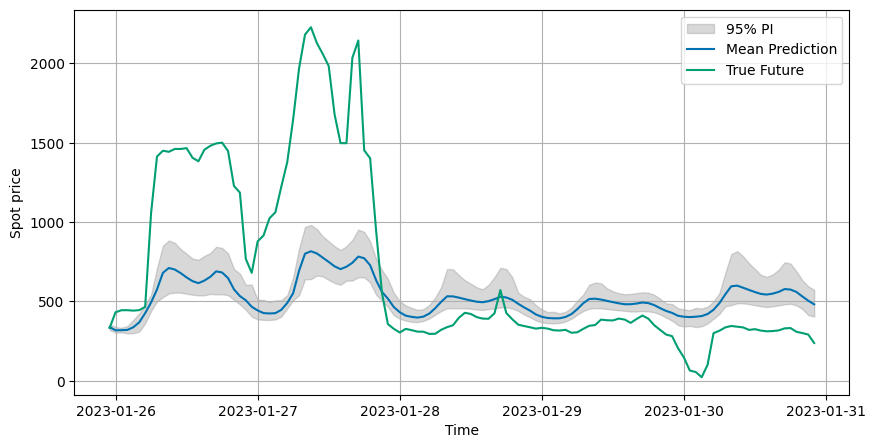

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.style.use('seaborn-colorblind')


time_index = dataset[start:end].spotPrice.tail(120).index
mean_prediction = np.mean(Y_hat, axis=0)
real_scaled = scaler_target.inverse_transform(real).squeeze()

plt.fill_between(time_index, z_lower, z_upper, color='gray', alpha= .3, lw = 1, label="95% PI")
plt.plot(time_index, mean_prediction, label="Mean Prediction")
plt.plot(time_index, scaler_target.inverse_transform(real).squeeze(), label="True Future")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Spot price")
plt.grid(axis= 'x')
plt.grid(axis= 'y')
plt.show()

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error


mae_ = mean_absolute_error (real_scaled, mean_prediction)
mse_ = mean_squared_error (real_scaled, mean_prediction)
rmse_ = root_mean_squared_error(real_scaled, mean_prediction)
smape_ = smape(real_scaled, mean_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


IndexError: index 4 is out of bounds for axis 0 with size 4

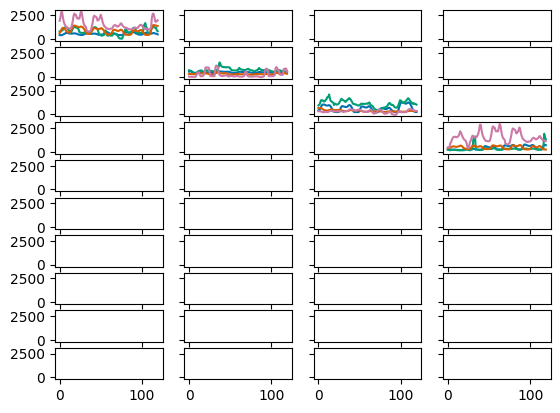

In [28]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(nrows=10, ncols=4, sharex='all', sharey='all')

for i, data in enumerate(test_windowed.take(40)):
  (past, future), truth = data

  pred = model.predict((past,future)) 

  row = i//2
  # col = i%2
  col = i // 2

  ax[row][col].plot(scaler_target.inverse_transform(pred.reshape(1, -1)).flatten(), label='Prediction')
  ax[row][col].plot(scaler_target.inverse_transform(truth.numpy().reshape(1, -1)).flatten(), label='Truth')

# Labeling axes
for i in range(2):
  ax[2][i].set_xlabel('Hour')
for i in range(3):
  ax[i][0].set_ylabel('Spot Price')

handles, labels = ax[0][0].get_legend_handles_labels()
fig.subplots_adjust(wspace=0, hspace=0.5)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.legend(handles, labels, loc='upper right')

In [30]:
prediction_set = test[2::120, :]

In [31]:
def create_predictions(df, n_deterministic_features,
                   window_size, forecast_size,
                   batch_size):

    # Total size of window is given by the number of steps to be considered
    # before prediction time + steps that we want to forecast
    total_size = window_size + forecast_size

    df = df.astype('float32')
    data = tf.data.Dataset.from_tensor_slices(df)
    
    # Selecting windows
    data = data.window(total_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda k: k.batch(total_size))

    # Extracting past features + deterministic future + labels
    data = data.map(lambda k: ((k[:-forecast_size],
                                k[-forecast_size:, -n_deterministic_features:]),
                               k[-forecast_size:, 0]))
    
    #tf.data.experimental.AUTOTUNE
    return data.batch(batch_size).prefetch(tf.data.AUTOTUNE)


prediction_windowed = create_dataset(prediction_set, futr_exog_list,
                               window_len, forecast_len,
                               batch_size=1)


In [35]:
preds = model.predict(prediction_windowed)

c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


ValueError: math domain error

In [36]:
import tensorflow_datasets as tfds

prediction_windowed_numpy = tfds.as_numpy(prediction_windowed)
x_ = []

for item in prediction_windowed_numpy:
    x, y = item
    x_.append(x)
    